In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import os.path

In [2]:
file_name = 'draft.csv'
draft = pd.DataFrame()
if not os.path.isfile(file_name):
    for i in range(2000, 2022 + 1):
        url = f'https://www.pro-football-reference.com/years/{i}/draft.htm'

        web_data = pd.read_html(url, header=1)[0]

        web_data['Season'] = i
        web_data = web_data.query('Tm != "Tm"')
        draft = pd.concat([draft, web_data])

    conditions = [
        draft['Tm'] == 'SDG',
        draft['Tm'] == 'OAK',
        draft['Tm'] == 'STL',
    ]
    choices = ['LAC', 'LV', 'LAR']

    draft['Tm'] = np.select(conditions, choices, default=draft['Tm'])
    draft.loc[draft['DrAV'].isnull(), "DrAV"] = 0

    draft.reset_index(drop=True, inplace=True)
    draft.to_csv(file_name, index=False)
else:
    draft = pd.read_csv(file_name)
    draft.loc[draft['DrAV'].isnull(), "DrAV"] = 0
    

draft.head()

,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,St,...,TD.1,Rec,Yds.2,TD.2,Solo,Int.1,Sk,College/Univ,Unnamed: 28,Season
0,1,1,CLE,Courtney Brown,DE,22.0,2005.0,0,0,4,...,0.0,0.0,0.0,0.0,156.0,NaN,19.0,Penn St.,College Stats,2000
1,1,2,WAS,LaVar Arrington,LB,22.0,2006.0,0,3,5,...,0.0,0.0,0.0,0.0,338.0,3.0,23.5,Penn St.,College Stats,2000
2,1,3,WAS,Chris Samuels,T,23.0,2009.0,0,6,9,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,Alabama,College Stats,2000
3,1,4,CIN,Peter Warrick,WR,23.0,2005.0,0,0,4,...,2.0,275.0,2991.0,18.0,3.0,NaN,NaN,Florida St.,College Stats,2000
4,1,5,BAL,Jamal Lewis,RB,21.0,2009.0,1,1,9,...,58.0,221.0,1879.0,4.0,NaN,NaN,NaN,Tennessee,College Stats,2000


In [4]:
draft_use = draft[['Season', 'Pick', 'Tm', 'Player', 'Pos', 'wAV', 'DrAV']]
draft_use.head()

,Season,Pick,Tm,Player,Pos,wAV,DrAV
0,2000,1,CLE,Courtney Brown,DE,27.0,21
1,2000,2,WAS,LaVar Arrington,LB,46.0,45
2,2000,3,WAS,Chris Samuels,T,63.0,63
3,2000,4,CIN,Peter Warrick,WR,27.0,25
4,2000,5,BAL,Jamal Lewis,RB,69.0,53


In [9]:
draft_use_pre2019 = draft_use.query('Season <= 2019')
draft_use_pre2019 = draft_use_pre2019.astype({'DrAV': float})
draft_use_pre2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5095 entries, 0 to 5094
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Season  5095 non-null   int64  
 1   Pick    5095 non-null   int64  
 2   Tm      5095 non-null   object 
 3   Player  5095 non-null   object 
 4   Pos     5095 non-null   object 
 5   wAV     4590 non-null   float64
 6   DrAV    5095 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 318.4+ KB


<Axes: xlabel='Pick', ylabel='DrAV'>

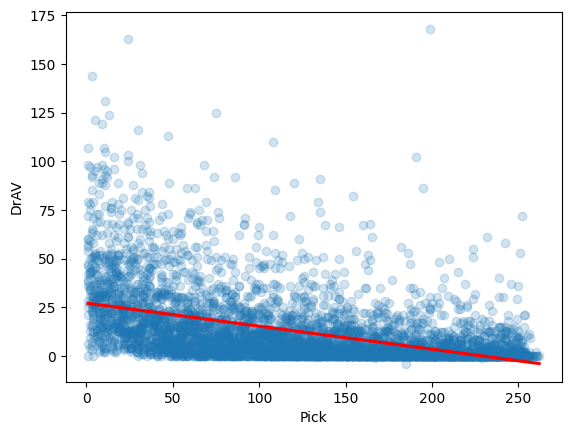

In [12]:
sns.regplot(x='Pick', y='DrAV', data=draft_use_pre2019, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.2})

<Axes: xlabel='Pick', ylabel='roll_DrAV'>

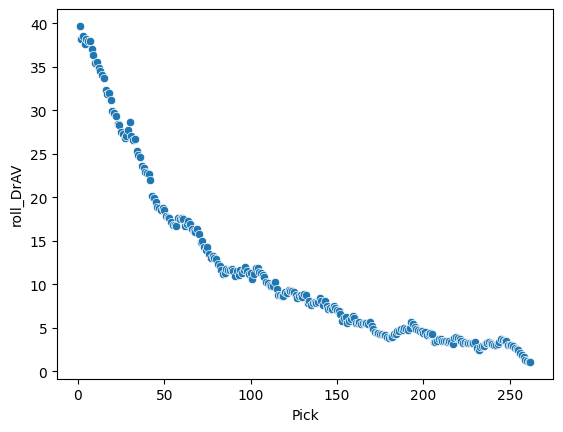

In [19]:
draft_chart = draft_use_pre2019 \
    .groupby(['Pick']) \
    .agg({'DrAV': ['mean']})

draft_chart.columns = list(map(''.join, draft_chart.columns.values))

draft_chart.loc[draft_chart['DrAVmean'].isnull()] = 0

draft_chart['roll_DrAV'] = draft_chart['DrAVmean'].rolling(window=13, min_periods=1, center=True).mean()

draft_chart.reset_index(inplace=True)

draft_chart['roll_DrAV_log'] = np.log(draft_chart['roll_DrAV'] + 1)

DrAV_pick_fit = smf.ols('roll_DrAV_log ~ Pick', data=draft_chart).fit()

sns.scatterplot(x='Pick', y='roll_DrAV', data=draft_chart)

In [20]:
DrAV_pick_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          roll_DrAV_log   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     8661.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):          1.24e-201
Time:                        20:05:31   Log-Likelihood:                 177.64
No. Observations:                 262   AIC:                            -351.3
Df Residuals:                     260   BIC:                            -344.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5042      0.015    229.351      0.000       3.474       3.534
Pick          -0.0094      0.000    -93.064      0.000      -0.010      -0.009
==============================================================================
Omnibus:                        3.257   Durbin-Watson:                   0.102
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                3.333
Skew:                           0.259   Prob(JB):                        0.189
Kurtosis:                       2.810   Cond. No.                         304.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
draft_chart['fitted_DrAV'] = np.exp(DrAV_pick_fit.predict()) - 1
draft_chart.head()

,Pick,DrAVmean,roll_DrAV,roll_DrAV_log,fitted_DrAV
0,1,48.55,39.721429,3.706754,31.944398
1,2,40.55,38.212500,3.668996,31.637045
2,3,45.10,38.533333,3.677144,31.332559
3,4,31.80,37.630000,3.654029,31.030914
4,5,43.80,38.254545,3.670067,30.732083


In [22]:
draft_use_pre2019 = draft_use_pre2019.merge(draft_chart[['Pick', 'fitted_DrAV']], on='Pick')
draft_use_pre2019['OE'] = draft_use_pre2019['DrAV'] - draft_use_pre2019['fitted_DrAV']
draft_use_pre2019 \
    .groupby('Tm') \
    .agg({'OE': ['mean', 'std', 'count']}) \
    .reset_index() \
    .sort_values([('OE', 'mean')], ascending=False)

Tm        OE                 
             mean        std count
26  PIT  3.534859  19.095611   161
11  GNB  3.386590  20.154470   180
8   DAL  2.679941  17.516794   160
21  NOR  2.288985  18.464473   131
1   ATL  2.259130  16.176404   148
22  NWE  2.105997  20.880910   176
13  IND  1.912485  15.961917   162
2   BAL  1.780894  17.205000   170
4   CAR  1.771378  16.482606   148
27  SEA  1.504339  17.200233   181
16  LAC  1.395223  14.785452   144
15  KAN  0.560638  15.642846   154
5   CHI  0.545215  16.117472   149
25  PHI  0.543516  15.941381   162
20  MIN  0.532209  14.182743   167
6   CIN  0.483473  15.952565   176
30  TEN  0.102539  12.840006   172
14  JAX  0.100018  13.117788   158
28  SFO  0.037012  14.001077   184
12  HOU -0.245187  12.918335   145
31  WAS -0.475935  10.077106   150
24  NYJ -0.671260  13.287991   138
0   ARI -0.698296  14.426891   149
3   BUF -0.816066  13.153614   161
29  TAM -0.836311  11.888169   153
23  NYG -1.010036  12.582401   144
17  LAR -1.434389  12.534798   175
19  MIA -1.474824  10.692740   151
9   DEN -1.500458  12.822847   159
10  DET -1.754165  12.193979   155
18   LV -2.615016  10.534381   162
7   CLE -3.501837  10.910348   170